## 用于试验带与不带BatchNorm的VGG_A网络结构对于CIFAR-10数据集上的分类效果

配置环境

In [6]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os

定义dataloader

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

cifar_root = '/Users/lvangge/Documents/ /code/codes_/神经网络深度学习/pj2'
def load_data(root,is_train,transform):
    set = torchvision.datasets.CIFAR10(root=cifar_root, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(set, batch_size=128, shuffle=True, num_workers=4,pin_memory=True)
    return dataloader

print('dataloader done')

dataloader done


定义init_weight

In [9]:
def init_weights_(m):
    """
    Initializes weights of m according to Xavier normal method.

    :param m: module
    :return:
    """
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

    elif isinstance(m, nn.BatchNorm1d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

定义VGG_A网络

In [10]:
class VGG_A(nn.Module):
    """VGG_A model

    size of Linear layers is smaller since input assumed to be 32x32x3, instead of
    224x224x3
    """

    def __init__(self, inp_ch=3, num_classes=10, init_weights=True):
        super().__init__()

        self.features = nn.Sequential(
            # stage 1
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))

        if init_weights:
            self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x.view(-1, 512 * 1 * 1))
        return x

    def _init_weights(self):
        for m in self.modules():
            init_weights_(m)

定义VGG_BatchNorm

In [11]:
class VGG_A_BatchNorm(nn.Module):
    """VGG_A_BatchNorm model

    size of Linear layers is smaller since input assumed to be 32x32x3, instead of
    224x224x3
    
    add batchnorm layer each stage after conventional layer
    """

    def __init__(self, inp_ch=3, num_classes=10, init_weights=True):
        super().__init__()

        self.features = nn.Sequential(
            # stage 1
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))

        if init_weights:
            self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x.view(-1, 512 * 1 * 1))
        return x

    def _init_weights(self):
        for m in self.modules():
            init_weights_(m)

定义训练函数和测试函数

In [22]:
def train(dataloader, loss_func, optimizer, model, device):
    size = len(dataloader.dataset)
    num_batch = len(dataloader)
    train_loss, train_err = 0, 0
    loss_list = []
    grads = []
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_func(pred, y)
        optimizer.zero_grad()
        
        if model.classifier[4].weight.grad is not None:
            grads.append(model.classifier[4].weight.grad.clone())
        else:
            grads.append(None)
    
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        train_loss += loss.item()
        train_err += (torch.argmax(F.softmax(pred, dim=1), dim=1) != y).type(torch.float).sum().item()

    train_loss /= num_batch
    train_err /= size

    return train_loss, train_err, grads, loss_list

def test(dataloader, loss_func, optimizer, model, device):
    size = len(dataloader.dataset)
    num_batch = len(dataloader)
    test_loss, test_err = 0, 0
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_func(pred, y)

        test_loss += loss.item()
        test_err += (torch.argmax(F.softmax(pred, dim=1), dim=1) != y).type(torch.float).sum().item()

    test_loss /= num_batch
    test_err /= size

    return test_loss, test_err

### 定义主训练框架

采用交叉熵损失函数，Adam优化器,设置学习率lr=1e-3,weight_decay=1e-4,训练20轮

导出dataloader

In [13]:
trainloader = load_data(cifar_root, is_train=True, transform=transform)
testloader = load_data(cifar_root, is_train=False, transform=transform)

100%|██████████| 170498071/170498071 [00:04<00:00, 35054371.24it/s]


Extracting /Users/lvangge/Documents/ /code/codes_/神经网络深度学习/pj2/cifar-10-python.tar.gz to /Users/lvangge/Documents/ /code/codes_/神经网络深度学习/pj2
Files already downloaded and verified


数据储存路径

In [15]:
loss_path = '/kaggle/working/loss_'
grads_path = '/kaggle/working/grads_'
path = [loss_path, grads_path]

训练框架

In [16]:
def net_train(Model, lr=1e-3, epochs=20, print_result=True, save_path=None):
    model = Model()
    if print_result:
        summary(model, input_size=(3,32,32), device='cpu')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)
    
    loss_func = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

    train_loss = []
    train_err = []
    test_loss = []
    test_err = []
    grads = []
    losses_list = []
    start_time = time.time()
    
    if save_path is not None:
        loss_folder = save_path[0]
        grads_folder = save_path[1]
        name = f'{Model.__name__}_{str(lr)}'
        
        loss_path = loss_folder+name+'.csv'
        with open(loss_path, 'w') as f:
            pass  
        
        grads_path = grads_folder+name+'.csv'
        with open(grads_path, 'w') as f:
            pass  
        
        with open('/kaggle/working/_model'+f'{Model.__name__}_str(lr).pth', 'w') as f:
            pass

    for epoch in range(epochs):
        model.train()
        e_train_loss, e_train_err, e_grads, e_loss = train(trainloader, loss_func, optimizer, model, device=device)

        model.eval()
        e_test_loss, e_test_err = test(testloader, loss_func, optimizer, model, device=device)

        train_loss.append(e_train_loss)
        train_err.append(e_train_err)
        test_loss.append(e_test_loss)
        test_err.append(e_test_err)
        grads.append(e_grads)
        losses_list.append(e_loss)
        
        if print_result:
            template = ('Epoch:{:2d}, train_err:{:.1f}%, train_loss:{:.3f}, test_err:{:.1f}%, test_loss:{:.3f}')
            if (epoch+1) % 2 == 0:
                print(template.format(epoch+1, e_train_err*100, e_train_loss, e_test_err*100, e_test_loss))
        
    end_time = time.time()
        
    torch.save(model, '/kaggle/working/_model'+f'{Model.__name__}_str(lr).pth')

    if print_result:
        print('runing time: {:.2f}s'.format(end_time - start_time))
    
    if save_path is not None:
#         loss_folder = save_path[0]
#         grads_foler = save_path[1]
#         name = f'{Model.__name__}_{str(lr)}'
        
#         loss_path = loss_folder+name+'.csv'
#         with open(loss_path, 'w') as f:
#             pass  
        
#         grads_path = grads_folder+name+'.csv'
#         with open(grads_path, 'w') as f:
#             pass  
        
        np.savetxt(loss_path, train_loss, fmt='%s', delimiter=' ')
        np.savetxt(grads_path, grads, fmt='%s', delimiter=' ')
    
    return train_loss, train_err, test_loss, test_err, grads, list(itertools.chain(*losses_list))

先训练VGG_A

In [14]:
vgga_train_loss, vgga_train_err, vgga_test_loss, vgga_test_err, vgga_grads, _ = net_train(VGG_A, save_path=path)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            [-1, 51

训练VGG_A_BatchNorm

In [16]:
vgga_bn_train_loss, vgga_bn_train_err, vgga_bn_test_loss, vgga_bn_test_err, vgga_bn_grads, _ = net_train(VGG_A_BatchNorm, save_path=path)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
              ReLU-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
             ReLU-10            [-1, 256, 8, 8]               0
      BatchNorm2d-11            [-1, 256, 8, 8]             512
           Conv2d-12            [-1, 256, 8, 8]         590,080
             ReLU-13            [-1, 256, 8, 8]               0
      BatchNorm2d-14            [-1, 25

绘制训练效果图

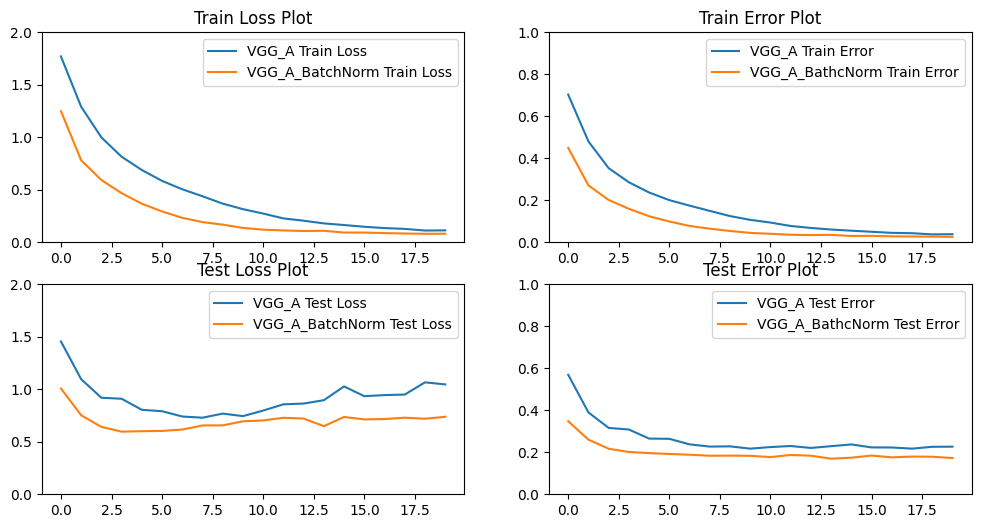

In [17]:
epochs = 20
def plot():
    epoch_range = range(epochs)
    plt.figure(figsize=(12,6))
    
    plt.subplot(2, 2, 1)
    plt.plot(epoch_range, vgga_train_loss, label='VGG_A Train Loss')
    plt.plot(epoch_range, vgga_bn_train_loss, label='VGG_A_BatchNorm Train Loss')
    plt.ylim(0,2)
    plt.legend()
    plt.title('Train Loss Plot')
    
    plt.subplot(2, 2, 2)
    plt.plot(epoch_range, vgga_train_err, label='VGG_A Train Error')
    plt.plot(epoch_range, vgga_bn_train_err, label='VGG_A_BathcNorm Train Error')
    plt.ylim(0,1)
    plt.legend()
    plt.title('Train Error Plot')
    
    plt.subplot(2, 2, 3)
    plt.plot(epoch_range, vgga_test_loss, label='VGG_A Test Loss')
    plt.plot(epoch_range, vgga_bn_test_loss, label='VGG_A_BatchNorm Test Loss')
    plt.ylim(0,2)
    plt.legend()
    plt.title('Test Loss Plot')
    
    plt.subplot(2, 2, 4)
    plt.plot(epoch_range, vgga_test_err, label='VGG_A Test Error')
    plt.plot(epoch_range, vgga_bn_test_err, label='VGG_A_BathcNorm Test Error')
    plt.ylim(0,1)
    plt.legend()
    plt.title('Test Error Plot')
    
    plt.show()

plot()

针对不同学习率，训练模型并存储数据

In [17]:
def get_max_min(alist):
  min_curve = [min(items) for items in zip(*alist)]
  max_curve = [max(items) for items in zip(*alist)]
  return min_curve, max_curve

In [20]:
def loss_landscape(Model):
    lr_range = [1e-4, 5e-4, 1e-3, 2e-3]
    losses_step = []
    for lr in lr_range:
        losses_step.append(net_train(Model, lr = lr, print_result=False, save_path=path)[-1])
    min_step, max_step = get_max_min(losses_step)
    
    return min_step, max_step

In [24]:
import itertools

vgga_min, vgga_max = loss_landscape(VGG_A)
vgga_bn_min, vgga_bn_max = loss_landscape(VGG_A_BatchNorm)

cuda
cuda
cuda
cuda
cuda
cuda
cuda
cuda


In [25]:
def plot_landscape(min_curve, max_curve, min_curve_bn, max_curve_bn, model_name, curve_name):
  x = list(range(len(max_curve)))
  x_bn = list(range(len(max_curve_bn)))

  plt.figure()
  plt.plot(min_curve, color=(0.0, 0.0, 0.5), alpha=0.7)
  plt.plot(max_curve, color=(0.0, 0.0, 0.5), alpha=0.7)

  plt.plot(min_curve_bn, color=(0.0, 0.5, 0.0), alpha=0.7)
  plt.plot(max_curve_bn, color=(0.0, 0.5, 0.0), alpha=0.7)

  plt.fill_between(x, min_curve, max_curve, color=(0.5, 0.5, 1.0), alpha=0.3, label='standard VGG')
  plt.fill_between(x_bn, min_curve_bn, max_curve_bn, color=(0.5, 1.0, 0.5), alpha=0.3, label='standard VGG + BatchNorm')

  plt.xlabel('Step')
  plt.ylabel(curve_name)
  plt.legend()

  # 显示图表
  plt.savefig(f'{model_name}\\lanscape_'+curve_name+'.png')

def plot_curve(standard, bn, model_name):
  x = list(range(len(standard)))
  x_bn = list(range(len(bn)))

  plt.figure()
  plt.plot(standard, color=(0.0, 0.0, 0.5), alpha=0.7, label='standard VGG')

  plt.plot(bn, color=(0.0, 0.5, 0.0), alpha=0.7, label='standard VGG + BatchNorm')

  plt.xlabel('Step')
  plt.ylabel('difference')
  plt.legend()

  # 显示图表
  plt.show()

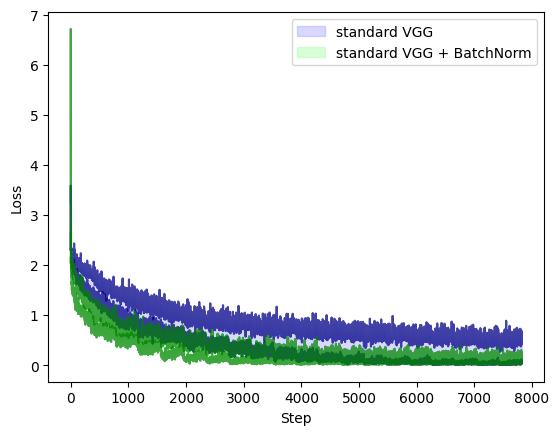

In [26]:
plot_landscape(vgga_min, vgga_max, vgga_bn_min, vgga_bn_max, 'VGG-A', 'Loss')